# This code is to get the labeled_energy_data csv file of each model

## 对数据进行分析,展示出来的内容包括:
### 1. 每个模型在 5 个 epochs 下的每个能耗数据点

## Import the lib

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

## find the data path

In [2]:
current_path = os.getcwd()
data_path = os.path.join(current_path, 'ModelsData')

## load all the model data

In [3]:
alexnet_data_folder = os.path.join(data_path, 'alexnet')

print(alexnet_data_folder)

/Users/dtjgp/Projects/GreenAI/3080/ModelsData/alexnet


## load the interpolate function

In [4]:
def integrate_power_over_interval(samples, start_time, end_time):
    # 假定 samples是按时间升序排序的 (t, p)
    # 若未排序，请先排序:
    # samples = sorted(samples, key=lambda x: x[0])
    
    def interpolate(samples, target_time):
        # 在 samples 中找到 target_time 左右最近的两个点，并进行线性插值
        # 若 target_time 恰好等于某个样本点时间，直接返回该点功率
        # 若无法找到两侧点（如 target_time在样本时间轴外），根据情况返回None或边界点
        n = len(samples)
        if n == 0:
            return None
        # 若 target_time 小于第一个样本点时间，无法向左插值，这里直接返回第一个点的功率值(或None)
        if target_time <= samples[0][0]:
            # 简化处理：返回最早样本点的功率（或None）
            return samples[0][1]
        # 若 target_time 大于最后一个样本点时间，无法向右插值，返回最后一个点的功率（或None）
        if target_time >= samples[-1][0]:
            return samples[-1][1]

        # 否则，在中间插值
        # 使用二分查找快速定位
        import bisect
        times = [t for t, _ in samples]
        pos = bisect.bisect_left(times, target_time)
        # pos是使times保持有序插入target_time的位置
        # 因为target_time不在已有样本点中，pos不会越界且pos>0且pos<n
        t1, p1 = samples[pos-1]
        t2, p2 = samples[pos]
        # 线性插值： p = p1 + (p2 - p1)*((target_time - t1)/(t2 - t1))
        ratio = (target_time - t1) / (t2 - t1)
        p = p1 + (p2 - p1)*ratio
        return p

    # 从原始 samples 中筛选出位于[start_time, end_time]内的点
    filtered = [(t, p) for t, p in samples if start_time <= t <= end_time]

    # 如果不足2个点，则尝试使用插值
    if len(filtered) < 2:
        # 无论如何都需要在边界处插值出两个点(起码start和end)
        start_power = interpolate(samples, start_time)
        end_power = interpolate(samples, end_time)

        # 如果从样本中无法插值出任何有意义的点（比如samples为空或无法插值），返回0.0
        if start_power is None or end_power is None:
            return 0.0

        # 将插值的边界点加入到 filtered
        # 注意：如果filtered中有一个点在区间内，我们也需要确保边界有两点以上
        # 例如filtered只有一个点在中间，则需要在start和end插值点全部加入。
        # 若filtered为空，则只用start/end两点插值点求积分
        new_filtered = [(start_time, start_power)] + filtered + [(end_time, end_power)]
        # 确保按时间排序
        new_filtered.sort(key=lambda x: x[0])
        filtered = new_filtered

    # 正常积分计算
    if len(filtered) < 2:
        # 经过插值仍不够，返回0
        return 0.0

    total_energy = 0.0
    for i in range(len(filtered)-1):
        t1, p1 = filtered[i]
        t2, p2 = filtered[i+1]
        dt = t2 - t1
        avg_p = (p1 + p2)/2.0
        total_energy += avg_p * dt

    return total_energy

## AlexNet

### find the data path contents

In [5]:
# show the files in the folder 
for file in os.listdir(alexnet_data_folder):
    print(file)

forward.npy
energy_consumption_file.csv
optimize.npy
labeled_energy_data.csv
backward.npy
to_device_energy.npy
to_device.npy
backward_energy.npy
optimize_energy.npy
loss_energy.npy
forward_energy.npy
loss.npy


In [6]:
# load the csv files 
energy_data = pd.read_csv(os.path.join(alexnet_data_folder, 'energy_consumption_file.csv'))
labeled_energy_data = pd.read_csv(os.path.join(alexnet_data_folder, 'labeled_energy_data.csv'))

# load the npy files
to_device = np.load(os.path.join(alexnet_data_folder, 'to_device.npy'), allow_pickle=True)
forward = np.load(os.path.join(alexnet_data_folder, 'forward.npy'), allow_pickle=True)
loss = np.load(os.path.join(alexnet_data_folder, 'loss.npy'), allow_pickle=True)
backward = np.load(os.path.join(alexnet_data_folder, 'backward.npy'), allow_pickle=True)
optimize = np.load(os.path.join(alexnet_data_folder, 'optimize.npy'), allow_pickle=True)

# load the energy data
to_device_energy = np.load(os.path.join(alexnet_data_folder, 'to_device_energy.npy'), allow_pickle=True)
forward_energy = np.load(os.path.join(alexnet_data_folder, 'forward_energy.npy'), allow_pickle=True)
loss_energy = np.load(os.path.join(alexnet_data_folder, 'loss_energy.npy'), allow_pickle=True)
backward_energy = np.load(os.path.join(alexnet_data_folder, 'backward_energy.npy'), allow_pickle=True)
optimize_energy = np.load(os.path.join(alexnet_data_folder, 'optimize_energy.npy'), allow_pickle=True)

In [7]:
# show the shape of the npy files
print(to_device.shape, forward.shape, loss.shape, backward.shape, optimize.shape)

(5, 235, 2) (5, 235, 2) (5, 235, 2) (5, 235, 2) (5, 235, 2)


In [8]:
# print out some values to check
print(to_device_energy[0][0][0], to_device_energy[0][0][1], to_device_energy[0][0][2])
print(forward[0][0][0], forward[0][0][1], forward_energy[0][0][2])

1733763031.8706045 1733763031.8843734 0.36419555616378785
1733763031.8843791 1733763032.226315 12.783496662139889


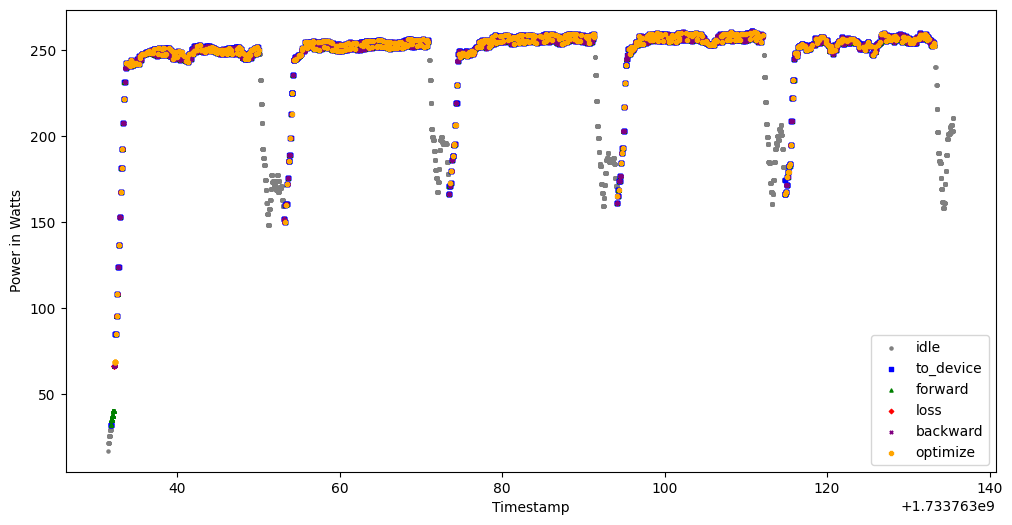

In [9]:
# Create a color map and marker map for the steps
step_colors = {
    'idle': 'gray',
    'to_device': 'blue',
    'forward': 'green',
    'loss': 'red',
    'backward': 'purple',
    'optimize': 'orange'
}

step_markers = {
    'idle': 'o',
    'to_device': 's',
    'forward': '^',
    'loss': 'D',
    'backward': 'x',
    'optimize': 'P'
}

# Plot the data with a larger figure size
fig, ax = plt.subplots(figsize=(12, 6))

# Plot each step with a different marker
for step in step_colors.keys():
    step_data = labeled_energy_data[labeled_energy_data['step'] == step]
    ax.scatter(step_data['timestamp'], step_data['power_in_watts'], color=step_colors[step], label=step, s=5, marker=step_markers[step])

ax.set_xlabel('Timestamp')
ax.set_ylabel('Power in Watts')
ax.legend()
plt.show()

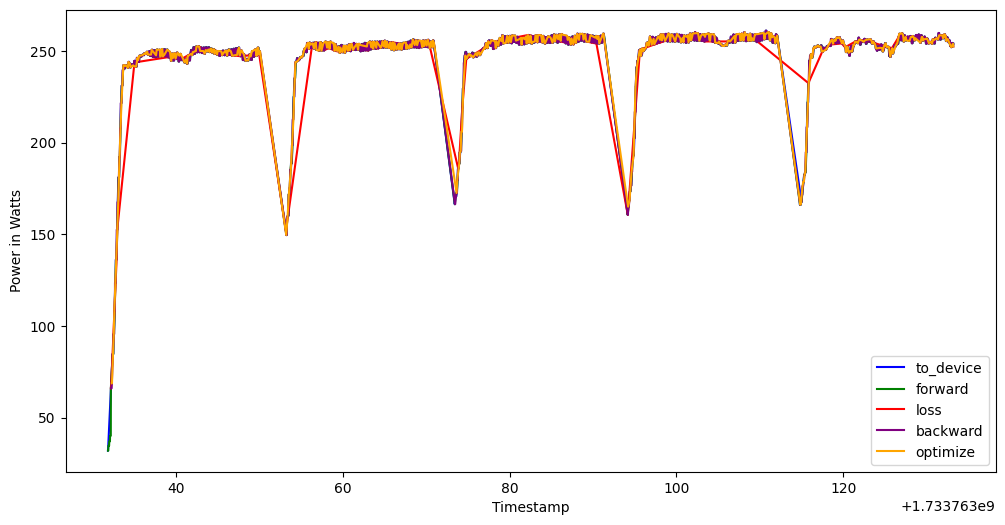

In [10]:
# Create a new figure and axis
fig, ax = plt.subplots(figsize=(12,6))

# Plot each step with a different color
for step in step_colors.keys():
    step_data = labeled_energy_data[labeled_energy_data['step'] == step]
    if step != 'idle':
        ax.plot(step_data['timestamp'], step_data['power_in_watts'], color=step_colors[step], label=step)

ax.set_xlabel('Timestamp')
ax.set_ylabel('Power in Watts')
ax.legend()
plt.show()

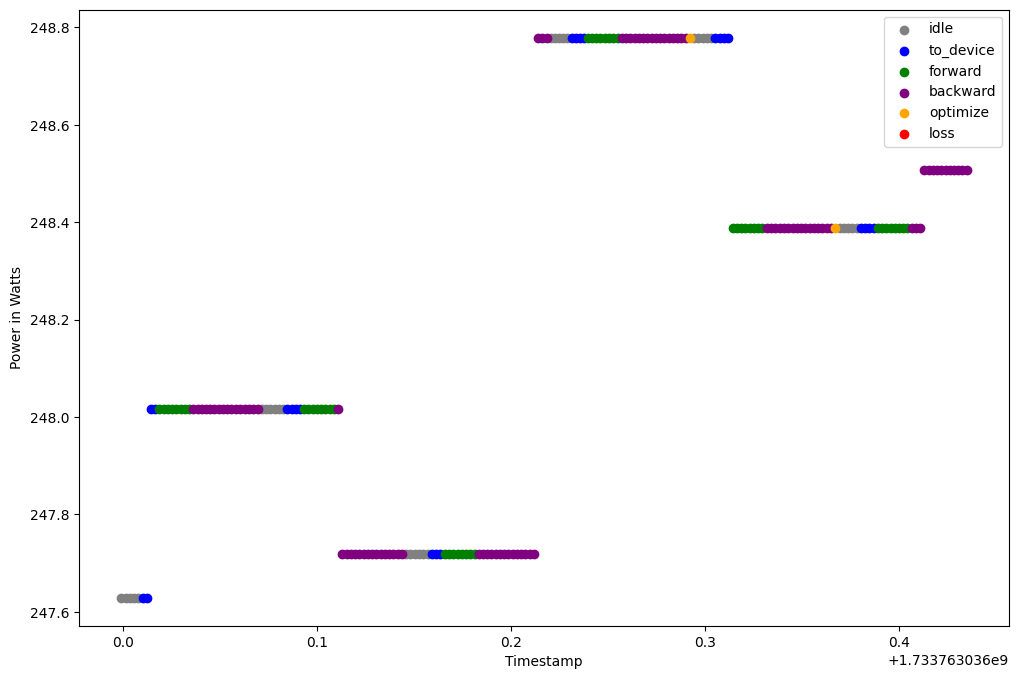

In [11]:
# Create a new figure and axis
fig, ax = plt.subplots(figsize=(12,8))

labeled_energy_data_rows = labeled_energy_data[2000:2200]

# Plot each step with a different color, except 'optimize' and 'loss'
for step in step_colors.keys():
    if step not in ['optimize', 'loss']:
        step_data = labeled_energy_data_rows[labeled_energy_data_rows['step'] == step]
        ax.scatter(step_data['timestamp'], step_data['power_in_watts'], color=step_colors[step], label=step)

# Plot 'optimize' and 'loss' steps last to ensure they are on top
for step in ['optimize', 'loss']:
    step_data = labeled_energy_data_rows[labeled_energy_data_rows['step'] == step]
    ax.scatter(step_data['timestamp'], step_data['power_in_watts'], color=step_colors[step], label=step)

ax.set_xlabel('Timestamp')
ax.set_ylabel('Power in Watts')
ax.legend()
plt.show()


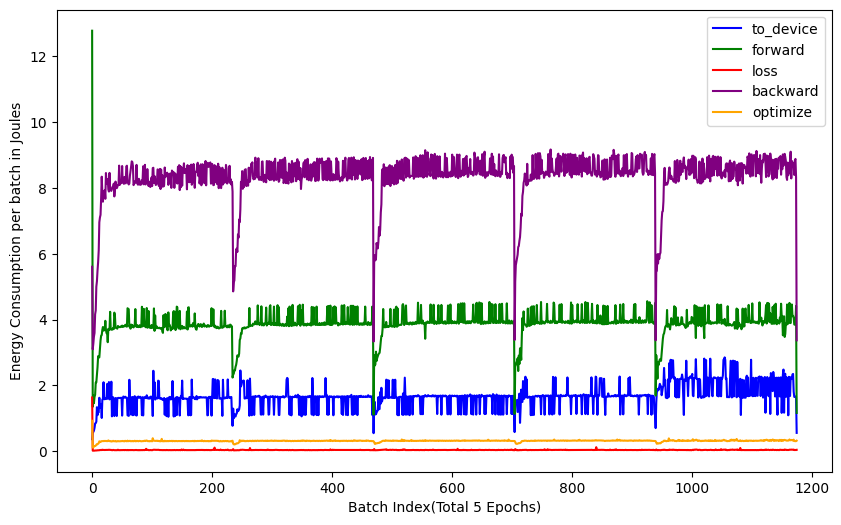

In [12]:
batch_info = ['to_device', 'forward', 'loss', 'backward', 'optimize']
energy_data_dict = {
    'to_device': to_device_energy,
    'forward': forward_energy,
    'loss': loss_energy,
    'backward': backward_energy,
    'optimize': optimize_energy
}

# plot the energy consumption for each step
fig, ax = plt.subplots(figsize=(10,6))
for step in batch_info:
    energy_data = energy_data_dict[step]
    energy_consumption = [energy_data[epoch][batch][2] for epoch in range(to_device.shape[0]) for batch in range(to_device.shape[1])]
    ax.plot(range(len(energy_consumption)), energy_consumption, color=step_colors[step], label=step)

ax.set_xlabel('Batch Index(Total 5 Epochs)')
ax.set_ylabel('Energy Consumption per batch in Joules')
ax.legend()
plt.show()


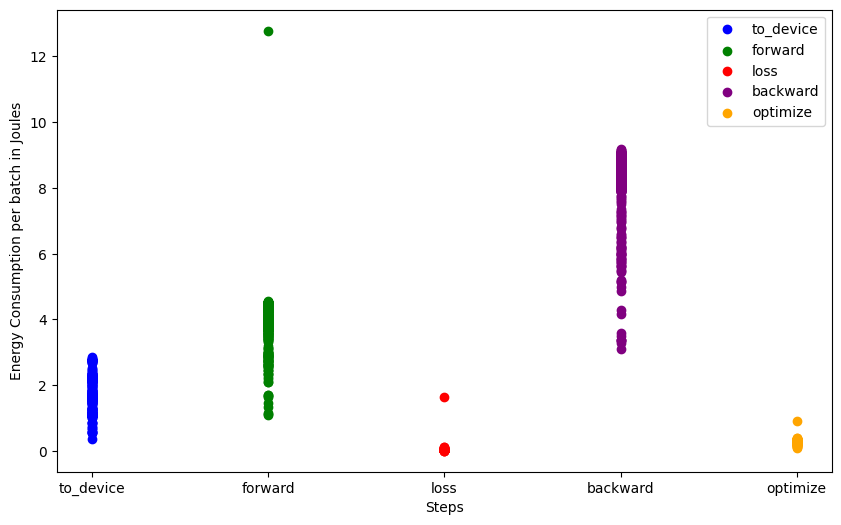

In [13]:
batch_info = ['to_device', 'forward', 'loss', 'backward', 'optimize']
energy_data_dict = {
    'to_device': to_device_energy,
    'forward': forward_energy,
    'loss': loss_energy,
    'backward': backward_energy,
    'optimize': optimize_energy
}

# plot the energy consumption for each step using dots
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate the average energy consumption for each step
average_energy_consumption = {step: np.mean([energy_data[epoch][batch][2] for epoch in range(to_device.shape[0]) for batch in range(to_device.shape[1])]) for step, energy_data in energy_data_dict.items()}

# Plot each step's energy consumption as a dot on the corresponding x-axis
for i, step in enumerate(batch_info):
    energy_data = energy_data_dict[step]
    energy_consumption = [energy_data[epoch][batch][2] for epoch in range(to_device.shape[0]) for batch in range(to_device.shape[1])]
    ax.scatter([i] * len(energy_consumption), energy_consumption, color=step_colors[step], label=step, marker='o')

# Set the x-axis labels to the batch_info
ax.set_xticks(range(len(batch_info)))
ax.set_xticklabels(batch_info)

ax.set_xlabel('Steps')
ax.set_ylabel('Energy Consumption per batch in Joules')
ax.legend()
plt.show()

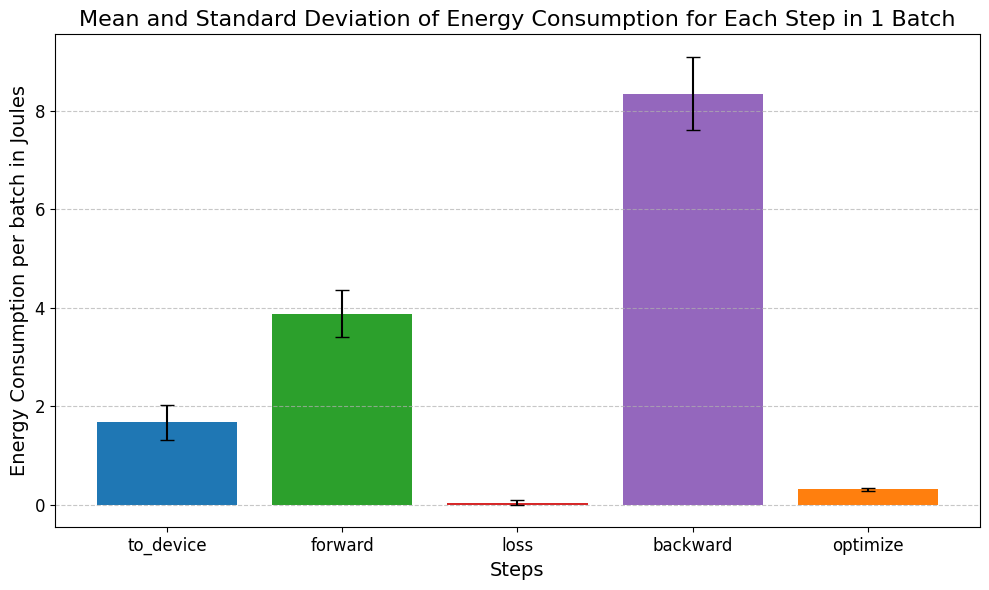

In [16]:
# Use a more subtle color palette
step_colors = {
    'idle': '#999999',  # light gray
    'to_device': '#1f77b4',  # muted blue
    'forward': '#2ca02c',  # muted green
    'loss': '#d62728',  # muted red
    'backward': '#9467bd',  # muted purple
    'optimize': '#ff7f0e'  # muted orange
}

# Calculate the mean and standard deviation for each step
mean_energy_consumption = {step: np.mean([energy_data[epoch][batch][2] for epoch in range(to_device.shape[0]) for batch in range(to_device.shape[1])]) for step, energy_data in energy_data_dict.items()}
std_energy_consumption = {step: np.std([energy_data[epoch][batch][2] for epoch in range(to_device.shape[0]) for batch in range(to_device.shape[1])]) for step, energy_data in energy_data_dict.items()}

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the mean energy consumption with error bars representing the standard deviation
steps = list(mean_energy_consumption.keys())
means = list(mean_energy_consumption.values())
stds = list(std_energy_consumption.values())

ax.bar(steps, means, yerr=stds, capsize=5, color=[step_colors[step] for step in steps])

# Set the x-axis and y-axis labels and title
ax.set_xlabel('Steps', fontsize=14)
ax.set_ylabel('Energy Consumption per batch in Joules', fontsize=14)
ax.set_title('Mean and Standard Deviation of Energy Consumption for Each Step in 1 Batch', fontsize=16)

# Improve the layout and aesthetics
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

### 分析设定的采样频率与真实的采样数据量之间的关系

In [22]:
# Calculate the total energy consumption for all the labeled_energy_data
# count the number of rows in the labeled_energy_data, which is the number of samples
number_of_samples = labeled_energy_data.shape[0]
print('Number of samples:', number_of_samples)

# get the start and end time of the labeled_energy_data
start_time = labeled_energy_data['timestamp'].iloc[0]
end_time = labeled_energy_data['timestamp'].iloc[-1]
print('Start time:', start_time)
print('End time:', end_time)

# Calculate the theorectical number of samples based on the sampling rate
sample_rate = 0.002 # 2ms
theoretical_number_of_samples = np.round((end_time - start_time) / sample_rate)
print('Theoretical number of samples:', theoretical_number_of_samples)

# calculate the missing rate
missing_rate = 1 - number_of_samples / theoretical_number_of_samples
print('Missing rate:', missing_rate)

Number of samples: 46954
Start time: 1733763031.4925056
End time: 1733763135.5443664
Theoretical number of samples: 52026.0
Missing rate: 0.09748971668012152
